###Installs and imports

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import torch

from collections import Counter
import re

from sklearn.feature_extraction.text import TfidfVectorizer #

from sklearn.model_selection import train_test_split, GridSearchCV #

from sklearn.svm import SVC #

from sklearn.naive_bayes import MultinomialNB #
from sklearn.linear_model import SGDClassifier, LogisticRegression #
from sklearn.multiclass import OneVsRestClassifier #
from sklearn.metrics import accuracy_score, classification_report #

from sklearn.ensemble import RandomForestClassifier


import nltk #
import string #
from nltk.corpus import stopwords #
from tqdm import tqdm
import joblib


from sklearn.preprocessing import LabelEncoder #

from google.colab import drive

from transformers import BertTokenizer, BertForSequenceClassification

###Drive mounting

In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/My Drive/dblp-v10.csv'

In [5]:
with open(data_path, "r") as f:
    print("File opened successfully!")


File opened successfully!


###Data load

Our data, in the venue prediction case, is 1.000.000 data instances initially.

Any data instance without an abstract or a venue is removed, so they aren't used in the training. This curation resulted in 723.768 different abstracts with their venues.

In [6]:
df = pd.read_csv(data_path)
print(f'Total papers before curation: {df.shape[0]}')

Total papers before curation: 1000000


In [7]:
df.dropna(subset=["abstract", "venue"], inplace=True)
df["abstract"] = df["abstract"].str.lower()
print(f'Total papers after curation: {df.shape[0]}')


Total papers after curation: 723768


The abstracts are preprocessed by lowercasing them and removing punctuation.

In [8]:

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

df['processed_abstract'] = df['abstract'].apply(preprocess_text)

The dataset is very large, with over 3000 different labels. Such complexity makes it difficult to obtain accurate predictions and relevant reccomendations. Thus, we plot the distribution of the number of papers per venue to see if all of this data is relevant.

count     3779.000000
mean       191.523684
std        587.955241
min          1.000000
25%          4.000000
50%         38.000000
75%        148.500000
max      11770.000000
Name: count, dtype: float64
venue
international conference on acoustics, speech, and signal processing    11770
international conference on robotics and automation                      9573
Lecture Notes in Computer Science                                        7606
international conference on communications                               7272
intelligent robots and systems                                           6968
international conference on image processing                             6757
global communications conference                                         6651
international geoscience and remote sensing symposium                    6098
Bioinformatics                                                           5875
conference on decision and control                                       5771
internatio

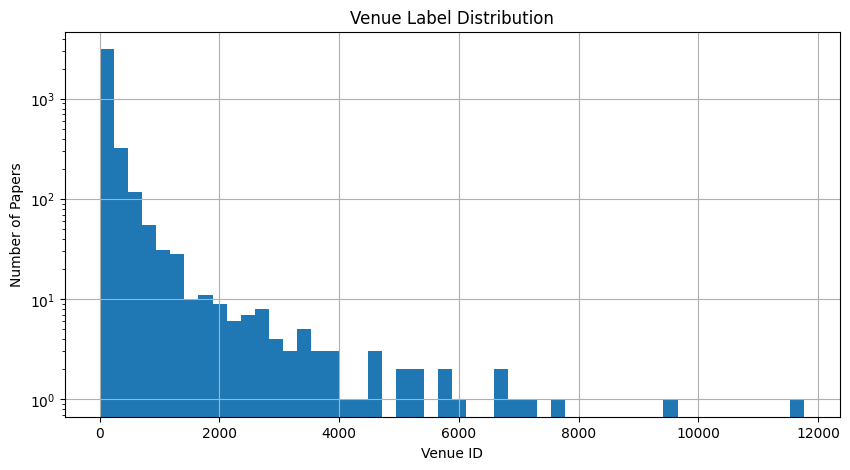

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

label_counts = df["venue"].value_counts()
print(label_counts.describe())
print(label_counts[:20])

plt.figure(figsize=(10,5))
label_counts.hist(bins=50)
plt.yscale("log")
plt.title("Venue Label Distribution")
plt.xlabel("Venue ID")
plt.ylabel("Number of Papers")
plt.show()


After plotting, we came to a realization that many venues have a very small number of submitted papers. Thus, we decided to simplify our data.

Firstly, venues with less than 500 papers were grouped into a single class called "Other". This effectively reduced the number of classes to around 300, however, so many labels still made it too complex to train models.

Thus, we decided to only consider N most popular venues. After exploration, we landed at 20 most popular venues, which yield 121.546 papers overall.

Thus, we reduced the number of labels around 180 times, while the dataset size only got reduced 6 times.

In [10]:
import pandas as pd

venue_counts = df["venue"].value_counts()

top_venues = venue_counts.nlargest(20).index

df = df[df["venue"].isin(top_venues)].copy()

df["venue"], venue_mapping = pd.factorize(df["venue"])

print(f"Number of venues after filtering: {df['venue'].nunique()}")

print("Updated Venue Mapping:")
print(dict(list(enumerate(venue_mapping))))
print(df.shape)


Number of venues after filtering: 20
Updated Venue Mapping:
(121546, 9)


In [37]:
venue_mapping_dict = dict(list(enumerate(venue_mapping)))

count       20.000000
mean      6077.300000
std       1924.726422
min       3922.000000
25%       4688.000000
50%       5519.000000
75%       6809.750000
max      11770.000000
Name: count, dtype: float64
venue
10    11770
0      9573
16     7606
3      7272
8      6968
12     6757
7      6651
13     6098
5      5875
14     5771
1      5267
19     5219
6      5176
11     5031
4      4698
18     4658
2      4584
9      4471
17     4179
15     3922
Name: count, dtype: int64


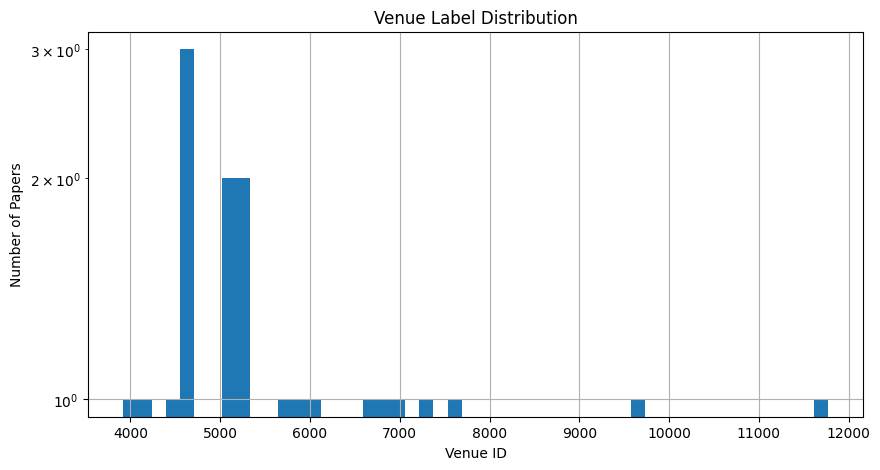

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

label_counts = df["venue"].value_counts()
print(label_counts.describe())
print(label_counts[:20])

# Plot distribution
plt.figure(figsize=(10,5))
label_counts.hist(bins=50)
plt.yscale("log")
plt.title("Venue Label Distribution")
plt.xlabel("Venue ID")
plt.ylabel("Number of Papers")
plt.show()


In [12]:
print(df['venue'])

8          0
13         1
29         2
42         3
50         4
          ..
999742     4
999745    11
999873    18
999883     2
999933    19
Name: venue, Length: 121546, dtype: int64


Since some venues have a large amount of submitted papers, class weights are very useful for balancing data for BERT and ML models.

In [13]:
import torch

class_counts = venue_counts.to_numpy()
class_weights = 1.0 / (class_counts + 1e-5)

class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Computed Class Weights:", class_weights[:20])


Computed Class Weights: tensor([0.0004, 0.0005, 0.0006, 0.0006, 0.0007, 0.0007, 0.0007, 0.0007, 0.0008,
        0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0011, 0.0012])


###ML Methods

We first explore some classical machine learning methods seen in class, together with the TF-IDF vectorizer.

In [15]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_abstract']).toarray()
y = df['venue']


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights using sklearn (for models that support it)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 0.6298484259619122, 1: 1.143683839096683, 2: 1.3079903147699758, 3: 0.8393991712707183, 4: 1.2995990376904571, 5: 1.0370733788395905, 6: 1.1757678355501813, 7: 0.9150762281197063, 8: 0.876789900811542, 9: 1.3733898305084746, 10: 0.5157861234882241, 11: 1.2100049776007964, 12: 0.9031766672859001, 13: 0.9995476973684211, 14: 1.0455483870967741, 15: 1.5419600380589915, 16: 0.7984562325505009, 17: 1.46, 18: 1.3016867469879518, 19: 1.1723655654690137}


In [19]:

num_labels = df["venue"].nunique()
print(f"Number of unique labels: {num_labels}")


Number of unique labels: 20


Note: the A100 PGU usage tokens ran out, so we went back to CPU-based ML models, which is why SVM and RF are uncommented. They took a very long time to execute on CPU.

In [21]:
priors = class_weights / class_weights.sum()

models = {
    "Logistic Regression": LogisticRegression(class_weight=class_weights_dict),
   #"SVM": SVC(class_weight="balanced"),
   # "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "Naive Bayes": MultinomialNB(class_prior=priors),
    "SGD + OneVsRest": OneVsRestClassifier(SGDClassifier(class_weight=class_weights_dict))
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: Accuracy = {acc:.4f}")

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


param_grid_sgd = {
    "estimator__loss": ["hinge", "log_loss"],
    "estimator__alpha": [1e-4, 1e-3],
    "estimator__max_iter": [1000, 500],
    "estimator__tol": [1e-3],
    "estimator__class_weight": ["balanced", class_weights_dict],
}
''' Takes a very long time, output is larg
grid_search_sgd = GridSearchCV(OneVsRestClassifier(SGDClassifier()), param_grid_sgd, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)

print("Best Parameters for SGD + OneVsRest:", grid_search_sgd.best_params_)
print("Best Score:", grid_search_sgd.best_score_)
'''


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.5805
Naive Bayes: Accuracy = 0.5283
SGD + OneVsRest: Accuracy = 0.5653
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.47      0.52      1854
           1       0.65      0.66      0.65      1016
           2       0.69      0.77      0.72       867
           3       0.35      0.24      0.28      1480
           4       0.45      0.56      0.50       957
           5       0.96      0.96      0.96      1187
           6       0.52      0.66      0.59      1041
           7       0.34      0.30      0.32      1338
           8       0.45      0.47      0.46      1423
           9       0.58      0.71      0.64       931
          10       0.71      0.40      0.51      2344
          11       0.42      0.54      0.47      1013
          12       0.51      0.57      0.54      1374
          13       0.88      0.90      0.89      1234
          14       0.69      0.76    

KeyboardInterrupt: 

###BERT

To further improve the system, we explore the BERT tokenizer and model for classification.

In [22]:
import torch

labels = torch.tensor(df["venue"].values, dtype=torch.long)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights /= class_weights.sum()  # Normalize

criterion_class = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))


In [23]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokens = tokenizer(df["processed_abstract"].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using device: cuda


In [24]:

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df["venue"].values, dtype=torch.long)

In [25]:
input_ids = input_ids.cpu()
attention_mask = attention_mask.cpu()
labels = labels.cpu()


###Data loaders

In [26]:

train_indices, test_indices = train_test_split(range(len(labels)), test_size=0.2, stratify=labels.cpu().numpy())
train_dataset = torch.utils.data.Subset(TensorDataset(input_ids, attention_mask, labels), train_indices)
test_dataset = torch.utils.data.Subset(TensorDataset(input_ids, attention_mask, labels), test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=torch.cuda.is_available())
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=torch.cuda.is_available())

num_labels = len(torch.unique(labels))
print(num_labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to(device)


class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights /= class_weights.sum()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))



20


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###BERT training

In [27]:

optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 5e-5}
], eps=1e-8, weight_decay=0.01)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=10 * len(train_dataloader))

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()
accumulation_steps = 1

epochs = 10
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct, total = 0, 0

    for step, batch in enumerate(train_dataloader):

        input_ids, attention_mask, labels = [t.to(device, non_blocking=True) for t in batch]
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss / accumulation_steps).backward()
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        with torch.no_grad():
            preds = torch.argmax(outputs.logits.softmax(dim=1), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader):.4f}, Accuracy: {correct/total:.4f}")

    # Unfreeze BERT after 3 epochs for faster training, but its a bit worse on performance
    if epoch == 2:
        for param in model.bert.parameters():
            param.requires_grad = True


<ipython-input-27-312fa56d83b0>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-27-312fa56d83b0>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):  # Ensure efficient mixed precision


Epoch 1/10, Loss: 1.5273, Accuracy: 0.4779
Epoch 2/10, Loss: 1.1015, Accuracy: 0.5825
Epoch 3/10, Loss: 0.9895, Accuracy: 0.6143
Epoch 4/10, Loss: 0.9098, Accuracy: 0.6393
Epoch 5/10, Loss: 0.8494, Accuracy: 0.6575
Epoch 6/10, Loss: 0.7944, Accuracy: 0.6740
Epoch 7/10, Loss: 0.7499, Accuracy: 0.6886
Epoch 8/10, Loss: 0.7172, Accuracy: 0.6986
Epoch 9/10, Loss: 0.6935, Accuracy: 0.7065
Epoch 10/10, Loss: 0.6770, Accuracy: 0.7126


###Token saving

In [ ]:
import torch

# Assuming 'tokens' is your tokenized data (e.g., from tokenizer(...))
torch.save(tokens['input_ids'], 'input_ids.pt')
torch.save(tokens['attention_mask'], 'attention_mask.pt')

In [ ]:
from google.colab import files
files.download('input_ids.pt')
files.download('attention_mask.pt')

###Evaluation

In [28]:
# Evaluate the trained model
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))

Test Accuracy: 0.6144
              precision    recall  f1-score   support

           0       0.62      0.50      0.56      1915
           1       0.64      0.64      0.64      1053
           2       0.76      0.76      0.76       917
           3       0.29      0.14      0.19      1455
           4       0.49      0.66      0.56       940
           5       0.99      0.99      0.99      1175
           6       0.57      0.67      0.62      1035
           7       0.35      0.41      0.38      1330
           8       0.49      0.57      0.53      1394
           9       0.63      0.75      0.69       894
          10       0.69      0.45      0.55      2354
          11       0.43      0.58      0.50      1006
          12       0.51      0.68      0.58      1351
          13       0.92      0.94      0.93      1220
          14       0.73      0.75      0.74      1154
          15       0.77      0.81      0.79       784
          16       0.68      0.53      0.59      1521
     

In [29]:

model.save_pretrained("bert_venue_prediction")
tokenizer.save_pretrained("bert_venue_prediction")

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


###Testing

In [40]:
import torch
from transformers import BertTokenizer, BertModel

def test_my_model_on_sample_abstract(abstract: str):
    tokenizer = BertTokenizer.from_pretrained('./bert_venue_prediction')
    model = BertForSequenceClassification.from_pretrained('./bert_venue_prediction')

    inputs = tokenizer(abstract, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    predicted_venue = predicted_class
    print("Predicted Venue Name:", venue_mapping_dict[predicted_venue])
    return predicted_venue

sample_abstract = ( #given by chat gpt
        "Recent advances in artificial intelligence have significantly improved natural language processing tasks. "
        "This paper discusses state-of-the-art techniques in deep learning, particularly focusing on transformer architectures "
        "and their applications in language understanding."
    )

test_outputs = test_my_model_on_sample_abstract(sample_abstract)


Predicted Venue Name: neural information processing systems


###Real-life example
Now that we have a working reccomendation system, lets see where it would suggest Dimitrije to send his Bachelor thesis

In [41]:
thesis_abstract_dimitrije = ("Complex urban environments are among the most difficult situations for Autonomous Vehicles."
"Because of this, (Autonomous Driving) AD algorithms have to be tested in large amounts of scenarios, which in turn increases costs and development time."
"Large amounts of generated data, as well as risks of accidents, with both material and human cost, make the physical approach to testing difficult."
"Thus, it is beneficial to shift focus towards hyper-realistic traffic simulators to train and improve the AD algorithms. "
"In this project, we use CARLA traffic simulator, combined with Robot Operating System (ROS2) to construct a data pipeline using the Heex SDK trigger detection. "

)

test_outputs_thesis = test_my_model_on_sample_abstract(thesis_abstract_dimitrije)

Predicted Venue Name: intelligent robots and systems


Note from Dimitrije: Since my thesis was done in Robot Operating System (ROS2) and dealt with autonomous robotic systems, this venue seems very relevant!